## 01-EDA

#### Name: Emran Sabbagh

#### Student Number: 20088634

### Setup

The first thing I did was importing some libraries and setting the folder structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "MINST"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True
SEED = 6

In [2]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)


### Cleaning and EDA

I then read the datasets from the training csv files and printed their shapes

As seen below, df_customer_train contains 6577 rows and 15 columns, df_accounts_train contain 25012 rows and 2 columns and df_transactions_train contains 514611 rows and 3 columns

In [3]:
customers = f'{ROOT}/orig/customers_train.csv'
accounts = f'{ROOT}/orig/accounts_train.csv'
transactions = f'{ROOT}/orig/transactions_train.csv'

In [4]:
df_customer_train = pd.read_csv(customers)
df_accounts_train = pd.read_csv(accounts)
df_transactions_train = pd.read_csv(transactions)

print(df_customer_train.shape)
print(df_accounts_train.shape)
print(df_transactions_train.shape)

(6577, 15)
(25012, 2)
(514611, 3)


In [5]:
df_customer_train.head()

,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K


I then dropped all the rows that contain null values in all of the training datasets

In [6]:
df_customer_train = df_customer_train.dropna()
df_accounts_train = df_accounts_train.dropna()
df_transactions_train = df_transactions_train.dropna()

print(df_customer_train.shape)
print(df_accounts_train.shape)
print(df_transactions_train.shape)

(5831, 15)
(25012, 2)
(514611, 3)


I then checked for the number of duplicated rows based on the customer column in the 3 training datasets

I found that there are no duplicated columns in df_customer_train, there are 18435 duplicated rows in df_accounts_train and 506732 duplicated rows in the  df_transactions_train dataset

In [7]:
print(df_customer_train.duplicated(subset=['Customer']).sum())
print(df_accounts_train.duplicated(subset=['Customer']).sum())
print(df_transactions_train.duplicated(subset=['Customer']).sum())

0
18435
506732


I then decided to remove these duplicates.

For the df_customer_train I dropped all the duplicated rows based on the customer column

For the df_accounts_train I dropped all the duplicated rows based on the customer column

For the df_transactions_train I created 3 temporary datasets:

df_transactions_train_sum is df_transactions_train but aggregated based on the sum of the values of the column Amount of duplicated customers

df_transactions_train_mean is df_transactions_train but aggregated based on the mean of the values of the column Amount of duplicated customers

df_transactions_train_median is df_transactions_train but aggregated based on the median of the values of the column Amount of duplicated customers

I added the last two temporary datasets (df_transactions_train_mean and df_transactions_train_median) at a later stage as part of model performance enhancement

We can see below that the number of rows in the dataset have decreased which is good

In [8]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
# https://www.easytweaks.com/pandas-groupby-to-dataframe/
# https://www.kdnuggets.com/2022/11/4-ways-rename-pandas-columns.html

df_customer_train = df_customer_train.drop_duplicates(subset=['Customer'])
df_accounts_train = df_accounts_train.drop_duplicates(subset=['Customer'])

df_transactions_train_sum = df_transactions_train.groupby('Customer').agg('sum').reset_index()
df_transactions_train_sum.rename(columns={"Amount": "Amount_Sum"}, inplace=True)

df_transactions_train_mean = df_transactions_train.groupby('Customer').agg('mean').reset_index()
df_transactions_train_mean.rename(columns={"Amount": "Amount_Mean"}, inplace=True)

df_transactions_train_median = df_transactions_train.groupby('Customer').agg('median').reset_index()
df_transactions_train_median.rename(columns={"Amount": "Amount_Median"}, inplace=True)


print(df_customer_train.shape)
print(df_accounts_train.shape)
#print(df_transactions_train.shape)
print(df_transactions_train_sum.shape)
print(df_transactions_train_mean.shape)
print(df_transactions_train_median.shape)

(5831, 15)
(6577, 2)
(7879, 2)
(7879, 2)
(7879, 2)


I then merged the 3 temporary df_transactions_train datasets with the df_customer_train dataset

In [9]:
# https://ai.plainenglish.io/combining-and-merging-datasets-in-pandas-8e71e11b76fa

df_training = pd.merge(df_customer_train, df_transactions_train_sum, on='Customer')
df_training = pd.merge(df_training, df_transactions_train_mean, on='Customer')
df_training = pd.merge(df_training, df_transactions_train_median, on='Customer')

print(df_training.shape)
df_training.head()

(5831, 18)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K,4827.96,53.644000,40.20
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K,7709.97,102.799600,44.11
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K,3470.06,50.290725,29.07
3,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K,5202.04,59.114091,35.04
4,764982590,No,Silver,2018-10-01,4,6036.0,1409,4627.0,0.233,56.0,M,PhD,Married,2,€50K - €80K,1741.00,38.688889,25.16


I then merged the df_training dataset with the df_accounts_train dataset

In [10]:
####

df_training = pd.merge(df_training, df_accounts_train, on='Customer')
print(df_training.shape)
df_training.head()

####

(5831, 19)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median,Account
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K,4827.96,53.644000,40.20,Credit Card
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K,7709.97,102.799600,44.11,Credit Card
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K,3470.06,50.290725,29.07,Current
3,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K,5202.04,59.114091,35.04,Credit Card
4,764982590,No,Silver,2018-10-01,4,6036.0,1409,4627.0,0.233,56.0,M,PhD,Married,2,€50K - €80K,1741.00,38.688889,25.16,Mortgage


I then started doing some EDA, the EDA I did in here was to visualize the unique values of the categorical columns and to check how many times they are present.

The reason I wanted to check the unique values is that because I needed to convert these values from categorical to numerical (eg. M:1) so I can do the model building and to do that I had to know what are the unique categorical values so I can replace them with numbers

I first looked at the unique values of Churn column which is the target, the most common value is No and the least common is Yes

<AxesSubplot:>

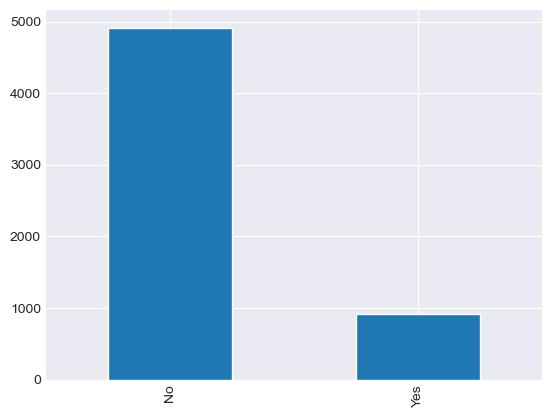

In [11]:
df_training['Churn'].value_counts().plot(kind='bar')

I then looked at the unique values of Gender column, the most common value is F and the least common is M

<AxesSubplot:>

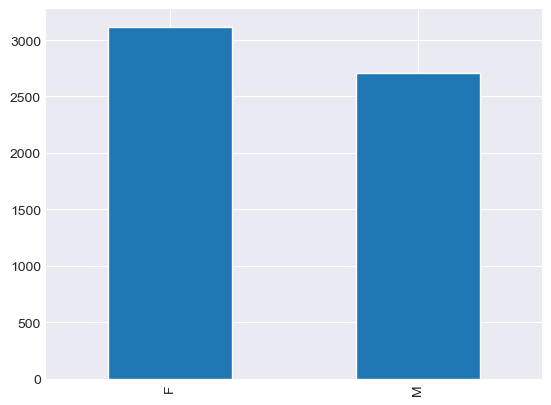

In [12]:
df_training['Gender'].value_counts().plot(kind='bar')

I then looked at the unique values of Marital_Status column, the most common value is Married and the least common is Divorced

<AxesSubplot:>

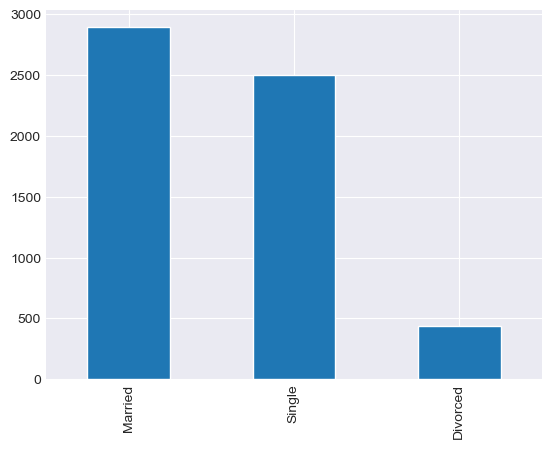

In [13]:
df_training['Marital_Status'].value_counts().plot(kind='bar')

I then looked at the unique values of Education column, the most common value is Graduate and the least common is PhD

<AxesSubplot:>

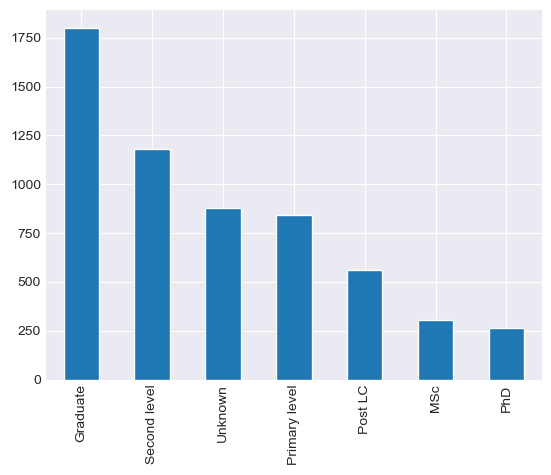

In [14]:
df_training['Education'].value_counts().plot(kind='bar')

I then looked at the unique values of Income column, the most common value is Less than 30K and the least common is 100K+

<AxesSubplot:>

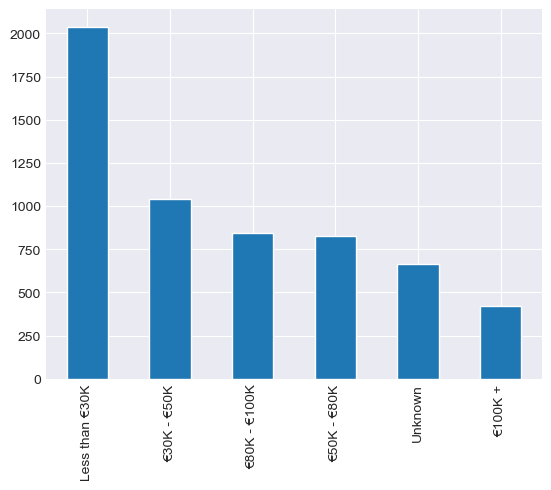

In [15]:
df_training['Income'].value_counts().plot(kind='bar')

I then looked at the unique values of Card column, the most common value is Silver and the least common is Black

<AxesSubplot:>

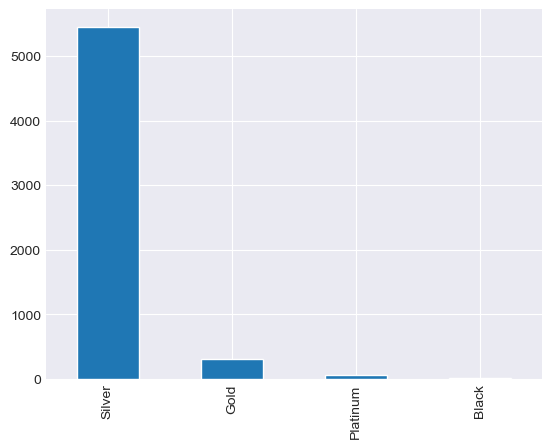

In [16]:
df_training['Card'].value_counts().plot(kind='bar')

I then looked at the unique values of Account column, the most common value is Credit Card and the least common is Joint

<AxesSubplot:>

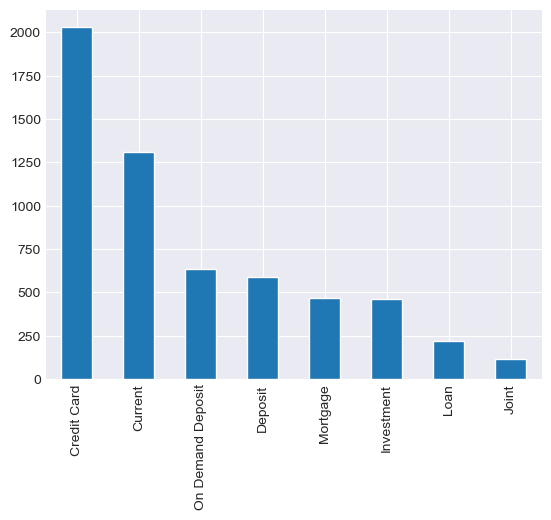

In [17]:
df_training['Account'].value_counts().plot(kind='bar')

I then replaced all the categorical values with numerical values

I also derived a new column called Start_Year from the Start_Date column and dropped the Start_Date column to enhance the model score

In [18]:
# https://towardsdatascience.com/how-to-replace-values-in-pandas-609ba7a031c9
# https://note.nkmk.me/en/python-pandas-str-slice/

df_training['Gender'] = df_training['Gender'].replace({'M':1, 'F': 2})
df_training['Marital_Status'] = df_training['Marital_Status'].replace({'Married':1, 'Single': 2, 'Divorced': 3})
df_training['Education'] = df_training['Education'].replace({'Graduate':1, 'Second level': 2, 'Unknown': 3,
                                                             'Primary level': 4, 'Post LC': 5, 'MSc': 6, 'PhD': 7})
df_training['Income'] = df_training['Income'].replace({'Less than €30K':29999, '€30K - €50K': 30001, '€80K - €100K': 80001, 
                                                       '€50K - €80K': 50001, 'Unknown':0, '€100K +':100001})
df_training['Card'] = df_training['Card'].replace({'Silver':1, 'Gold': 2, 'Platinum': 3, 'Black': 4})
df_training['Account'] = df_training['Account'].replace({'Credit Card':1, 'Current': 2, 'On Demand Deposit': 3, 'Deposit': 4, 'Mortgage': 5,
                                                         'Investment': 6, 'Loan': 7, 'Joint': 8})
df_training['Churn'] = df_training['Churn'].replace({'Yes':1, 'No': 0})
df_training['Start_Year'] = df_training['Start_Date'].str[:4].astype(int)


df_training = df_training.drop(columns=['Start_Date'])

df_training.head()

,Customer,Churn,Card,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median,Account,Start_Year
0,797197508,0,1,1,2315.0,1565,750.0,0.676,48.0,2,1,1,2,29999,4827.96,53.644000,40.20,1,2020
1,812854728,0,1,1,7645.0,2076,5569.0,0.272,58.0,2,2,2,5,29999,7709.97,102.799600,44.11,1,2020
2,768000743,0,1,2,6394.0,0,6394.0,0.000,55.0,2,2,2,2,29999,3470.06,50.290725,29.07,2,2020
3,759029725,0,1,4,1879.0,1486,393.0,0.791,37.0,2,2,2,1,29999,5202.04,59.114091,35.04,1,2021
4,764982590,0,1,4,6036.0,1409,4627.0,0.233,56.0,1,7,1,2,50001,1741.00,38.688889,25.16,5,2018


In [19]:
##########

##########
##########

##########

I then read the test datasets printed their shapes

In [20]:
customers = f'{ROOT}/orig/customers_test.csv'
accounts = f'{ROOT}/orig/accounts_test.csv'
transactions = f'{ROOT}/orig/transactions_test.csv'

In [21]:
df_customer_test = pd.read_csv(customers)
df_accounts_test = pd.read_csv(accounts)
df_transactions_test = pd.read_csv(transactions)

print(df_customer_test.shape)
print(df_accounts_test.shape)
print(df_transactions_test.shape)

(3542, 14)
(13575, 2)
(227447, 3)


I then dropped the rowswith null values from the test datasets, as seen below the number of rows stayed the same in the datasets so there was no rows with null values

In [22]:
df_customer_test = df_customer_test.dropna()
df_accounts_test = df_accounts_test.dropna()
df_transactions_test = df_transactions_test.dropna()

print(df_customer_test.shape)
print(df_accounts_test.shape)
print(df_transactions_test.shape)

(3542, 14)
(13575, 2)
(227447, 3)


I then checked the number of duplicated rows based on the Customer column

In [23]:
print(df_customer_test.duplicated(subset=['Customer']).sum())
print(df_accounts_test.duplicated(subset=['Customer']).sum())
print(df_transactions_test.duplicated(subset=['Customer']).sum())

0
10033
223905


I then did the same merging process I did for the training datasets on the test datasets

In [24]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
# https://www.easytweaks.com/pandas-groupby-to-dataframe/

df_customer_test = df_customer_test.drop_duplicates(subset=['Customer'])
df_accounts_test = df_accounts_test.drop_duplicates(subset=['Customer'])
#df_transactions_test = df_transactions_test.drop_duplicates(subset=['Customer'])
#df_transactions_test = df_transactions_test.groupby('Customer').agg('sum').reset_index()

df_transactions_test_sum = df_transactions_test.groupby('Customer').agg('sum').reset_index()
df_transactions_test_sum.rename(columns={"Amount": "Amount_Sum"}, inplace=True)

df_transactions_test_mean = df_transactions_test.groupby('Customer').agg('mean').reset_index()
df_transactions_test_mean.rename(columns={"Amount": "Amount_Mean"}, inplace=True)

df_transactions_test_median = df_transactions_test.groupby('Customer').agg('median').reset_index()
df_transactions_test_median.rename(columns={"Amount": "Amount_Median"}, inplace=True)

print(df_customer_test.shape)
print(df_accounts_test.shape)
#print(df_transactions_train.shape)
print(df_transactions_test_sum.shape)
print(df_transactions_test_mean.shape)
print(df_transactions_test_median.shape)

(3542, 14)
(3542, 2)
(3542, 2)
(3542, 2)
(3542, 2)


In [25]:
# https://ai.plainenglish.io/combining-and-merging-datasets-in-pandas-8e71e11b76fa

df_testing = pd.merge(df_customer_test, df_transactions_test_sum, on='Customer')
df_testing = pd.merge(df_testing, df_transactions_test_mean, on='Customer')
df_testing = pd.merge(df_testing, df_transactions_test_median, on='Customer')

print(df_testing.shape)
df_testing.head()

(3542, 17)


,Customer,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median
0,774663629,Gold,2020-01-01,2,29663.0,1743,27920.0,0.059,51,M,Graduate,Single,3,€50K - €80K,14638.00,157.397849,100.350
1,720420396,Silver,2020-11-01,2,2032.0,1195,837.0,0.588,45,F,Unknown,Divorced,3,€30K - €50K,4478.97,55.987125,32.380
2,815283379,Silver,2020-01-01,1,17268.0,1197,16071.0,0.069,57,M,Graduate,Single,3,€100K +,4077.01,45.300111,26.880
3,764861610,Silver,2020-05-01,3,2264.0,0,2264.0,0.000,38,F,Primary level,Single,2,Less than €30K,1204.02,43.000714,24.965
4,742798818,Silver,2020-01-01,1,2192.0,1464,728.0,0.668,45,F,MSc,Unknown,4,Less than €30K,4905.03,55.112697,34.660


In [26]:
####

df_testing = pd.merge(df_testing, df_accounts_test, on='Customer')
print(df_testing.shape)
df_testing.head()

####

(3542, 18)


,Customer,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median,Account
0,774663629,Gold,2020-01-01,2,29663.0,1743,27920.0,0.059,51,M,Graduate,Single,3,€50K - €80K,14638.00,157.397849,100.350,Credit Card
1,720420396,Silver,2020-11-01,2,2032.0,1195,837.0,0.588,45,F,Unknown,Divorced,3,€30K - €50K,4478.97,55.987125,32.380,Credit Card
2,815283379,Silver,2020-01-01,1,17268.0,1197,16071.0,0.069,57,M,Graduate,Single,3,€100K +,4077.01,45.300111,26.880,Current
3,764861610,Silver,2020-05-01,3,2264.0,0,2264.0,0.000,38,F,Primary level,Single,2,Less than €30K,1204.02,43.000714,24.965,Investment
4,742798818,Silver,2020-01-01,1,2192.0,1464,728.0,0.668,45,F,MSc,Unknown,4,Less than €30K,4905.03,55.112697,34.660,Joint


I then checked the unqiue categorical values in df_testing dataset so I can change those values to numerical values for model building

In [27]:
df_testing['Gender'].value_counts()

F    1839
M    1703
Name: Gender, dtype: int64

In [28]:
df_testing['Marital_Status'].value_counts()

Married     1642
Single      1337
Divorced     289
Unknown      274
Name: Marital_Status, dtype: int64

In [29]:
df_testing['Education'].value_counts()

Graduate         1100
Second level      673
Primary level     542
Unknown           538
Post LC           367
MSc               172
PhD               150
Name: Education, dtype: int64

In [30]:
df_testing['Income'].value_counts()

Less than €30K    1240
€30K - €50K        625
€80K - €100K       574
€50K - €80K        471
Unknown            372
€100K +            260
Name: Income, dtype: int64

In [31]:
df_testing['Card'].value_counts()

Silver      3285
Gold         209
Platinum      42
Black          6
Name: Card, dtype: int64

In [32]:
df_testing['Account'].value_counts()

Credit Card          1169
Current               814
On Demand Deposit     386
Deposit               363
Investment            309
Mortgage              275
Loan                  136
Joint                  90
Name: Account, dtype: int64

I then replaced all the categorical values with numerical values just as I did with the df_training dataset

In [33]:
# https://towardsdatascience.com/how-to-replace-values-in-pandas-609ba7a031c9
# https://note.nkmk.me/en/python-pandas-str-slice/

df_testing['Gender'] = df_testing['Gender'].replace({'M':1, 'F': 2})
df_testing['Marital_Status'] = df_testing['Marital_Status'].replace({'Married':1, 'Single': 2, 'Divorced': 3, 'Unknown': 0})
df_testing['Education'] = df_testing['Education'].replace({'Graduate':1, 'Second level': 2, 'Unknown': 3,
                                                             'Primary level': 4, 'Post LC': 5, 'MSc': 6, 'PhD': 7})
df_testing['Income'] = df_testing['Income'].replace({'Less than €30K':29999, '€30K - €50K': 30001, '€80K - €100K': 80001, 
                                                       '€50K - €80K': 50001, 'Unknown':0, '€100K +':100001})
df_testing['Card'] = df_testing['Card'].replace({'Silver':1, 'Gold': 2, 'Platinum': 3, 'Black': 4})
df_testing['Account'] = df_testing['Account'].replace({'Credit Card':1, 'Current': 2, 'On Demand Deposit': 3, 'Deposit': 4, 'Mortgage': 5,
                                                         'Investment': 6, 'Loan': 7, 'Joint': 8})

df_testing['Start_Year'] = df_testing['Start_Date'].str[:4].astype(int)


df_testing = df_testing.drop(columns=['Start_Date'])

df_testing.head()

,Customer,Card,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Amount_Sum,Amount_Mean,Amount_Median,Account,Start_Year
0,774663629,2,2,29663.0,1743,27920.0,0.059,51,1,1,2,3,50001,14638.00,157.397849,100.350,1,2020
1,720420396,1,2,2032.0,1195,837.0,0.588,45,2,3,3,3,30001,4478.97,55.987125,32.380,1,2020
2,815283379,1,1,17268.0,1197,16071.0,0.069,57,1,1,2,3,100001,4077.01,45.300111,26.880,2,2020
3,764861610,1,3,2264.0,0,2264.0,0.000,38,2,4,2,2,29999,1204.02,43.000714,24.965,6,2020
4,742798818,1,1,2192.0,1464,728.0,0.668,45,2,6,0,4,29999,4905.03,55.112697,34.660,8,2020


I then printed the shape of the df_training and df_testing datasets

In [34]:
print(df_training.shape)
print(df_testing.shape)

(5831, 19)
(3542, 18)


In [35]:
###################
##
###################

I then did more EDA to compare between the target column (Churn) and some other columns

The countplot below shows that the number of people who didn't churn is higher than the number of people who churned

<AxesSubplot:xlabel='Churn', ylabel='count'>

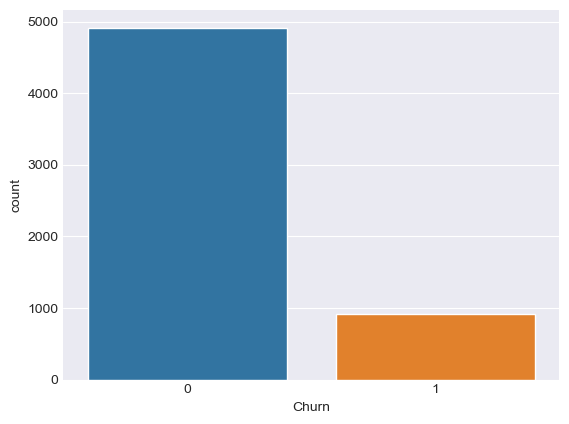

In [36]:
sns.countplot(x="Churn", data=df_training)

The countplot below shows that the number of females who churned and didn't churn is higher than the number of men who churned and didn't churn

<AxesSubplot:xlabel='Churn', ylabel='count'>

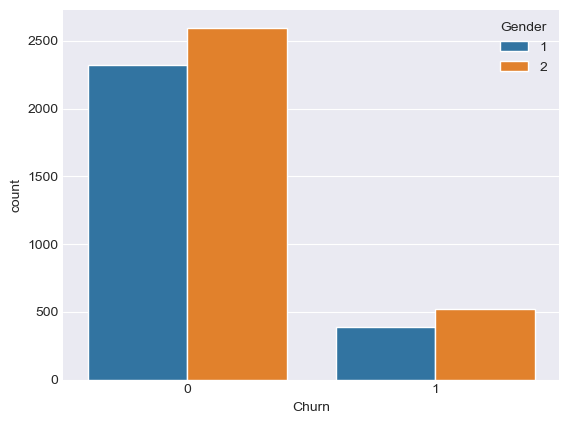

In [37]:
sns.countplot(data=df_training, x="Churn", hue="Gender")

The countplot below shows that the most used account by churners and non churners is Credit Card and the least used account by churners and non churners is Joint

<AxesSubplot:xlabel='Churn', ylabel='count'>

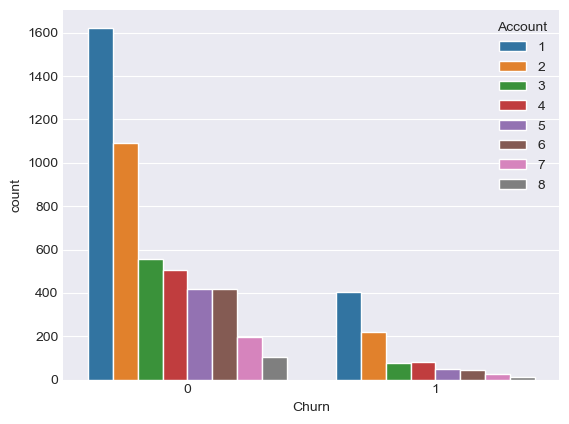

In [38]:
sns.countplot(data=df_training, x="Churn", hue="Account")

The countplot below shows that the most used card by churners and non churners is Silver

<AxesSubplot:xlabel='Churn', ylabel='count'>

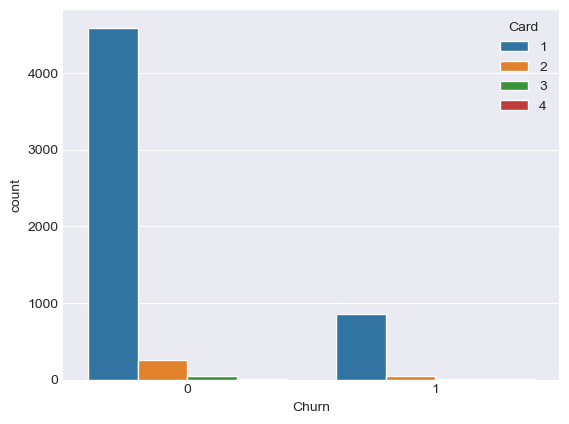

In [39]:
sns.countplot(data=df_training, x="Churn", hue="Card")

The countplot below shows that most of churners and non churners are Married

<AxesSubplot:xlabel='Churn', ylabel='count'>

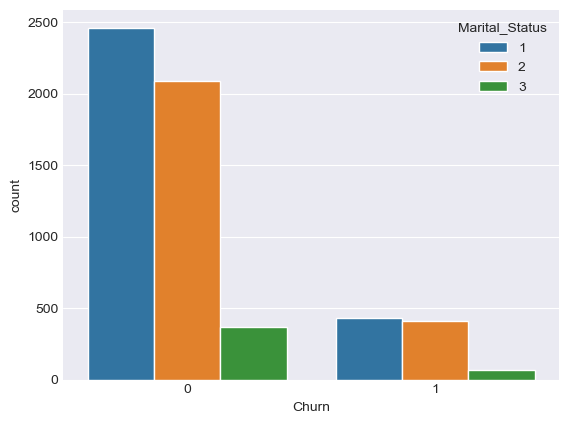

In [40]:
sns.countplot(data=df_training, x="Churn", hue="Marital_Status")

The countplot below shows that most of churners and non churners are Graduates

<AxesSubplot:xlabel='Churn', ylabel='count'>

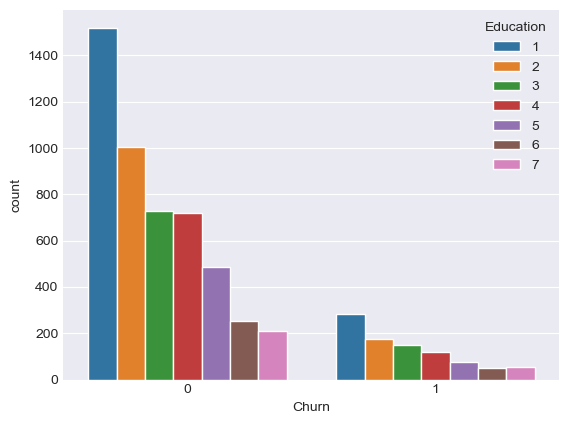

In [41]:
sns.countplot(data=df_training, x="Churn", hue="Education")

The countplot below shows that most of churners and non churners have income less than 30K

<AxesSubplot:xlabel='Churn', ylabel='count'>

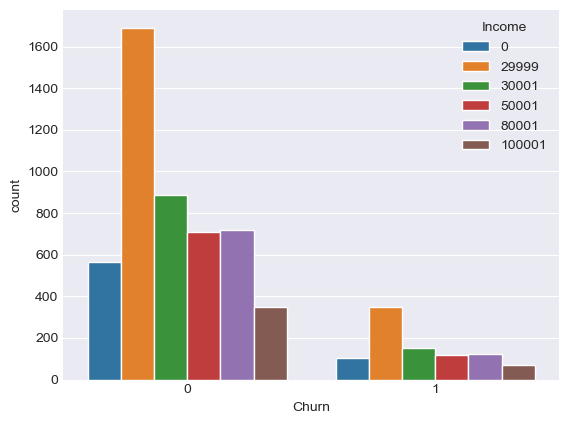

In [42]:
sns.countplot(data=df_training, x="Churn", hue="Income")

The boxplot below shows that the maximum age for churners is higher than the maximum age for non churners but they both have the same median age

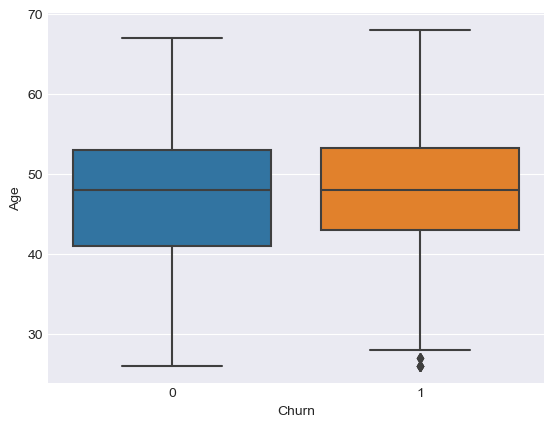

In [43]:
sns.boxplot( y=df_training["Age"], x=df_training["Churn"] );

The boxplot below shows that the maximum Amount_Sum for non churners is higher than the maximum Amount_Sum for churners and its median is higher

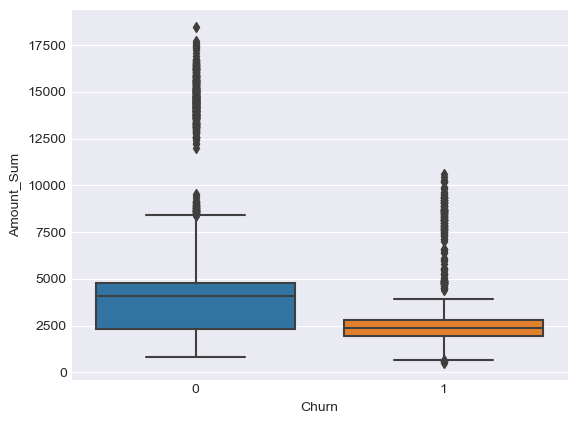

In [44]:
sns.boxplot( y=df_training["Amount_Sum"], x=df_training["Churn"] );

The boxplot below shows that the maximum number of Customer_Service_Calls for churners is higher than the maximum number of Customer_Service_Calls for non churners but they both have the same minimum number

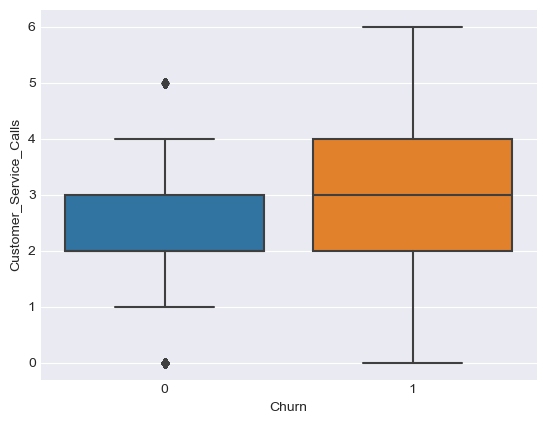

In [45]:
sns.boxplot( y=df_training["Customer_Service_Calls"], x=df_training["Churn"] );

The boxplot below shows that churners and non churners have the same maximum, minimum and median number of Dependents

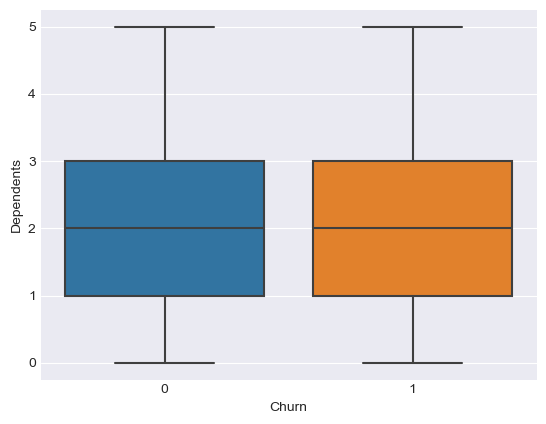

In [46]:
sns.boxplot( y=df_training["Dependents"], x=df_training["Churn"] );

The boxplot below shows that the median for Credit_Limit is higher for non churners than for churners but they have the same maximum Credit_Limit

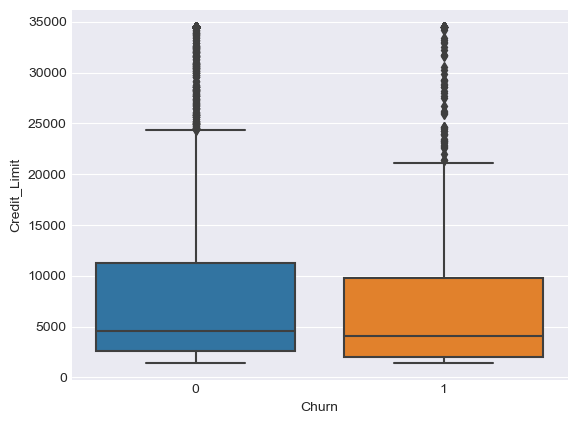

In [47]:
sns.boxplot( y=df_training["Credit_Limit"], x=df_training["Churn"] );

I then outputted the df_training and df_testing datasets to csv files called train.csv and test.csv

In [48]:
df_training.to_csv(f"{ROOT}/output/train.csv", index= False)
df_testing.to_csv(f"{ROOT}/output/test.csv", index= False)